## Random Forest
* **Notebook coded and completed by Adam Lang, Springboard Data Science Fellow**
* **Date: 5/9/2024**

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

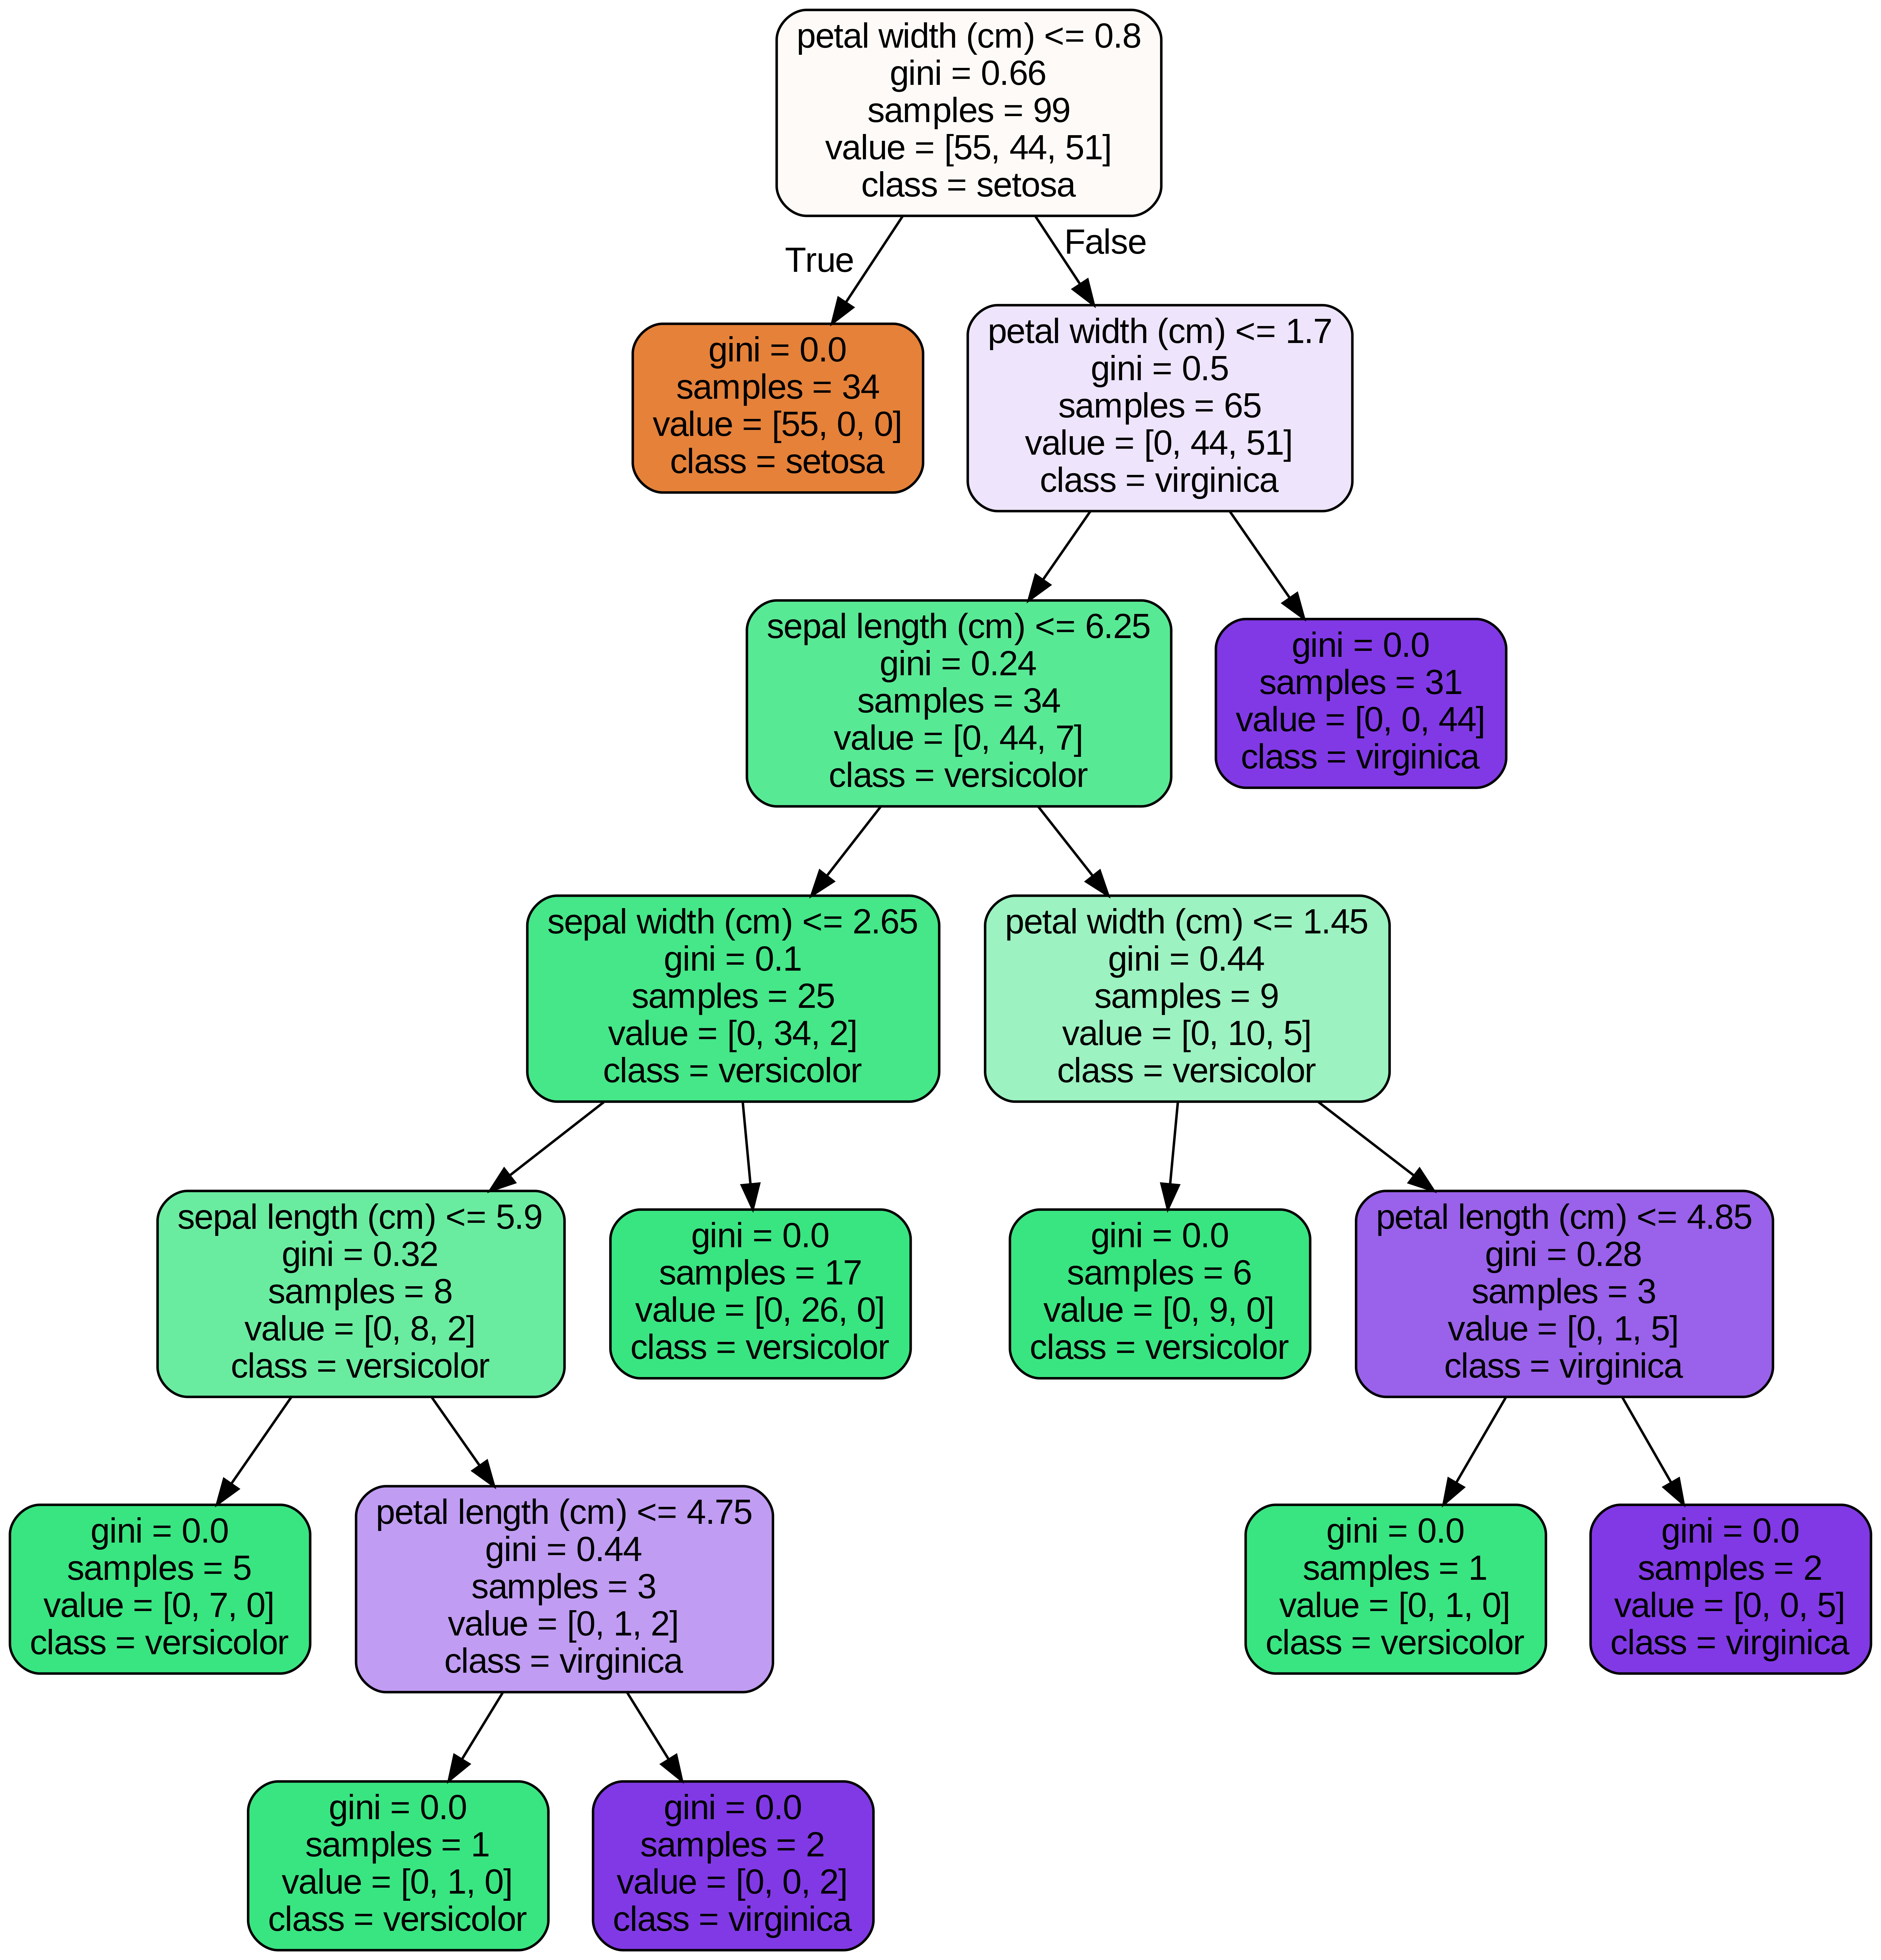

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country.

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic.

The goal of the case study is to build a Random Forest Classifier to **predict the 'state' of the patient.**

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

## import sklearn packages
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

### Dataset upload

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# dataset path
data_path = '/content/drive/MyDrive/Springboard_Data_Science/Supervised Learning/Ensemble Methods and Random Forests/PatientInfo.csv'

In [5]:
#url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
# load csv into pandas df
df = pd.read_csv(data_path)

## view head of df
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [6]:
# shape of df
df.shape

(2218, 18)

In [7]:
## df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

Observation:
* It appears there are no null values, but this may not be true as we dive further into the data.
* There are multiple datatypes of `float64` which may be an issue we have to deal with.
* We can also see the date variables such as `released_date`, `deceased_date`, `symptom_onset_date` are objects and not datetime data types. Also noted is the `birth_year` variable is a `float64` and not a datetime dtype.

In [8]:
## describe
df.describe()

,patient_id,global_num,birth_year,infection_order,infected_by,contact_number
count,2.218000e+03,1314.000000,1764.000000,42.000000,4.690000e+02,411.000000
mean,4.014678e+09,4664.816591,1974.988662,2.285714,2.600789e+09,24.128954
std,2.192419e+09,2874.044464,19.412643,1.254955,1.570638e+09,91.087792
min,1.000000e+09,1.000000,1916.000000,1.000000,1.000000e+09,0.000000
25%,1.700000e+09,1908.500000,1962.000000,1.250000,1.200000e+09,2.000000
50%,6.001000e+09,5210.500000,1974.500000,2.000000,2.000000e+09,5.000000
75%,6.004000e+09,7481.500000,1993.000000,3.000000,4.100000e+09,16.000000
max,7.000000e+09,8717.000000,2020.000000,6.000000,6.113000e+09,1160.000000


Observations:
* infection_order is an obvious categorical variable.
* As mentioned, birth_year needs to be changed from a float to a datetime.

In [9]:
#Get Counts of null values
na_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount'] > 0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


It appears 15 of the 18 columns have null values.

In [10]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

Observation:
* The **response variables show significant imbalance in the 3 classes.** Obviously this is related to the nature of the virus COVID-19, but it also suggests that our classification model may be more likely to predict the class (isolated) with the highest percentage of data points and less likely to predict the class with the least number of samples (deceased).
* This can lead to overfitting on the training data and a poor ability for the model to be able to generalize on unseen or new data.
* There are various techniques to evaluate if our model is overfitting with imbalanced target variables:
  * Accuracy - generally we probably want to avoid using this because it will measure the percent of correct predictions no matter what the prediction classes are.
  * Confusion Matrix - this can help assess this because while it will show the true positives as being quite high, it will truly reveal the fact that the model may not be able to correctly predict or classify the minority target classes which is significant information to know.
  * Precision and Recall
  * AUC-ROC curve
  * Matthews correlation coefficient
* There are techniques to handle the class imbalances including but not limited to:
  * Undersampling
  * Oversampling (SMOTE)
      * SMOTE is often a good choice because it does not subtract any information from the current dataset. However, it can often introduce noise/outliers into the dataset.
  * Ensemble Method
  * Class Weights
  * Focal Loss
* This was mostly an academic exercise for me to review and remember how to handle class imbalances. I have personally used the SMOTE technique before. Anyhow, we may not need to use these techniques, but it is good to identify the imbalance early on before we begin modeling.
* Source: https://python.plainenglish.io/handling-class-imbalance-in-machine-learning-cb1473e825ce

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**
 * **Note/Decision: it would be best to drop any null values from the dataset then comeback and take on the task of calculating age from the year column, I will do this further down in the notebook after taking care of null values.**

In [11]:
## first lets look at the birth_year column
df['birth_year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: birth_year
Non-Null Count  Dtype  
--------------  -----  
1764 non-null   float64
dtypes: float64(1)
memory usage: 17.5 KB


In [12]:
## lets review the null values
df['birth_year'].isna().sum()

454

Observations:
* It is strange that the birth_year is a float, so we are definitely going to have to convert this to datetime to help with calculating age.
* We also can see there are 454 NaN values in the column which will make it difficult to do any dtype conversions and calculations across the entire column.
* **Decision: it would be best to drop any null values from the dataset then comeback and take on the task of calculating age from the year column.**

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [13]:
print(df.isnull().sum().sort_values(ascending=False))

disease               2199
deceased_date         2186
infection_order       2176
symptom_onset_date    2025
released_date         1995
contact_number        1807
infected_by           1749
infection_case        1055
global_num             904
birth_year             454
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
province                 0
country                  0
patient_id               0
dtype: int64


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [15]:
## view disease column values
df['disease'].value_counts(dropna=False)

disease
NaN     2199
True      19
Name: count, dtype: int64

In [16]:
## now fill missing values with 0 and remap True to 1
df['disease'] = df['disease'].map({True:1}).fillna(0).astype('int')

In [17]:
# check value_counts of disease again
df['disease'].value_counts(dropna=False)

disease
0    2199
1      19
Name: count, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [18]:
# first let's check column names
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state'],
      dtype='object')

In [19]:
## fillna with df.mean()
df.fillna(df[['global_num','birth_year','infection_order','infected_by','contact_number']].mean(),inplace=True)

In [20]:
# check null values for these cols again
df[['global_num','birth_year','infection_order','infected_by','contact_number']].isna().sum()

global_num         0
birth_year         0
infection_order    0
infected_by        0
contact_number     0
dtype: int64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [21]:
## check what other cols have missing values
df.isnull().sum().sort_values(ascending=False)

deceased_date         2186
symptom_onset_date    2025
released_date         1995
infection_case        1055
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
disease                  0
global_num               0
infection_order          0
infected_by              0
contact_number           0
province                 0
country                  0
birth_year               0
patient_id               0
dtype: int64

In [22]:
## Let's see a quick reminder of the dataframe columns
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


For the remaining missing values I am going to fill them with the **mode.**

In [23]:
## Loop through df and fill remaining missing values with the mode
for col in df.columns:
  df[col].fillna(df[col].mode()[0], inplace=True)

**<font color='teal'> Check for any remaining null values.</font>**

In [24]:
# check if all null values have been handled
df.isnull().sum()

patient_id            0
global_num            0
sex                   0
birth_year            0
age                   0
country               0
province              0
city                  0
disease               0
infection_case        0
infection_order       0
infected_by           0
contact_number        0
symptom_onset_date    0
confirmed_date        0
released_date         0
deceased_date         0
state                 0
dtype: int64

## Create a new column named 'n_age' which is the calculated age based on the birth year column.
* Now we will create this column since we removed all NaN values.

In [25]:
## first let's check the dtype of birth_year col
df['birth_year'].dtypes

dtype('float64')

In [26]:
## Now transform birth_year column to datetime object
df['birth_year'] = df['birth_year'].astype('int')
# print dtype
df['birth_year'].dtypes

dtype('int64')

In [27]:
# print birth_year value_counts
df['birth_year'].value_counts()

birth_year
1974    483
1969     54
1995     51
1998     47
1996     45
       ... 
2010      2
2011      2
1925      1
1916      1
1931      1
Name: count, Length: 96, dtype: int64

Before I calculate the age based on birth_year, I want to see what year to use to calculate age based on symptom_onset_date

In [28]:
## First transform column symptom_onset_date to datetime object
df['symptom_onset_date'] = df['symptom_onset_date'].astype('datetime64[ns]')
#df['symptom_onset_date'].dt.year.value_counts()

In [29]:
# check dtype again for symptom_onset_date
df['symptom_onset_date'].dtypes

dtype('<M8[ns]')

In [30]:
# Now look at year value_counts for symptom_onset_date
df['symptom_onset_date'].dt.year.value_counts()

symptom_onset_date
2020    2218
Name: count, dtype: int64

Observation:
* We have confirmed the symptom onset date is 2020. Certainly we don't have to use this date as we could use the `timedelta` function to calculate the patient's age from today's date. However, I feel it makes the most sense to use the symptom_onset_date which is clearly the year 2020 to calculate the patient's age since it gives us a better feature representation of the the patient's age related to the dataset.

In [31]:
# we will use 2020 as the year to calculate the age and create new column n_age
## we don't need timedelta here because we only need the year
df['n_age'] = 2020 - df['birth_year']

In [32]:
# look at n_age value_counts()
df['n_age'].value_counts()

n_age
46     483
51      54
25      51
22      47
24      45
      ... 
10       2
9        2
95       1
104      1
89       1
Name: count, Length: 96, dtype: int64

## Plot `n_age` column - examine dataset distribution

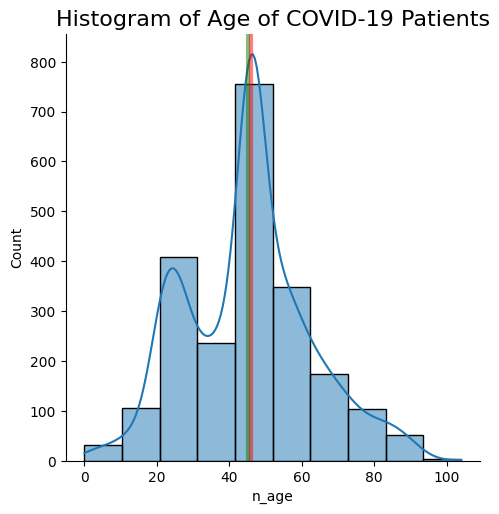

In [33]:
## lets plot a histogram of the n_age
sns.displot(x='n_age',data=df,bins=10,kde=True) #calculated bins by davies and goldsmith rule of np.sqrt of data points
plt.title("Histogram of Age of COVID-19 Patients",fontsize=16)
plt.axvline(x=df.n_age.mean(), linewidth=3, color='g', label="mean", alpha=0.5)
plt.axvline(x=df.n_age.median(), linewidth=3, color='r', label="median", alpha=0.5)
plt.show();

Observations
* The age distribution is bi-modal with the mean and median just above 40 years.
* The lower peak appears just above age 20. The highest peak is at the mean and median.
* It is interesting to see there is a long gradual tail around age 60 to 100 years. Does this suggest that the average COVID-19 patient in South Korea was between 20 and 40 years old?
  * In the USA most patients with fatalities were older: https://www.statista.com/statistics/1191568/reported-deaths-from-covid-by-age-us/
  * However, we can recall from earlier we saw the target variable in this dataset titled "disease" that most of these patients were isolated and very few deceased. We do know that globally younger patients were usually isolated and survived. Again we will see what our machine learning model predicts for disease state, but this again confirms that there are younger patients in this dataset thus infering the predicted outcome of isolation and survival.
  * Furthermore, we also know the death rates for elderly patients were quite high in South Korea with even smaller death rates for younger people than the USA as seen in this source: https://www.statista.com/statistics/1105088/south-korea-coronavirus-mortality-rate-by-age/
    * Thus this confirms that we can infer our model may be biased towards younger patients who were isolated and survived.

Remove date columns from the data.


In [34]:
## drop the date columns from the dataset
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [35]:
## print out nunique() values in dataset
print(df.nunique().sort_values(ascending=False))

## also print out the len of this
print(f"The number of nunique values in dataset are: {len(df.nunique())}\n")

patient_id         2218
global_num         1304
infected_by         207
city                134
birth_year           96
n_age                96
contact_number       73
province             17
infection_case       16
age                  11
infection_order       7
country               4
state                 3
sex                   2
disease               2
dtype: int64
The number of nunique values in dataset are: 15



Observations:
* There are 15 features or variables with unique values.
* The top few are: patient_id, global_num, infected_by, and city.
* Although these are all categorical variables, the bottom 5 appear to be discrete as there are only a finite number of values. The varible infection_order may be ordinal.

Review the percent of unique values by column.

In [36]:
# print percent of unique vals by columne
print(round((df.nunique()/df.shape[0])*100,2))

patient_id         100.00
global_num          58.79
sex                  0.09
birth_year           4.33
age                  0.50
country              0.18
province             0.77
city                 6.04
disease              0.09
infection_case       0.72
infection_order      0.32
infected_by          9.33
contact_number       3.29
state                0.14
n_age                4.33
dtype: float64


Review the range of values per column.

In [37]:
## range of values per column --> .describe().T
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974786e+03,1.731583e+01,1.916000e+03,1.965000e+03,1.974000e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.521371e+01,1.731583e+01,0.000000e+00,3.200000e+01,4.600000e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [38]:
## Check for duplicated rows
duplicateRowsDF = df[df.duplicated(keep=False)]
duplicateRowsDF


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


* There appears to be no duplicated rows in our dataset.

Print the categorical columns and their associated levels.

In [39]:
## set up a categorical datafram --> dfo
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape

#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,134
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [40]:
# create a numeric df
df_numeric = df.select_dtypes(include=[np.number])

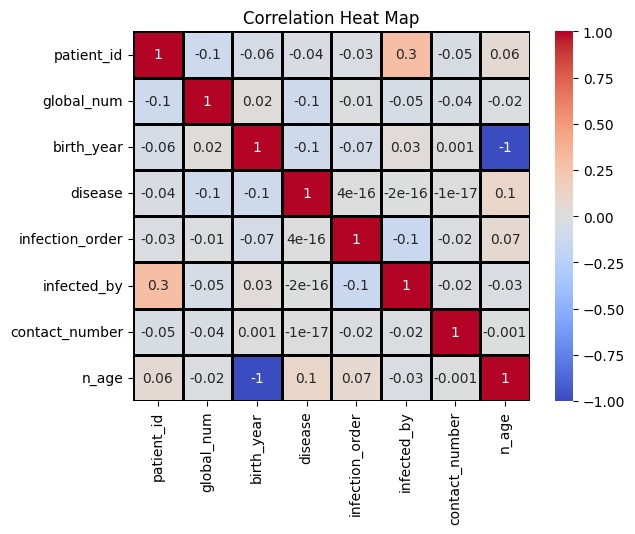

In [41]:
# create corr variable
corr = df_numeric.corr()
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black',fmt='.1g').set(title="Correlation Heat Map")
plt.show();

## Observations from Correlation Heat Map
* infected by is somewhat correlated with patient_id with a value of 0.3
* disease and age are mildly correlated with a value of 0.1.
* There are a significant amount of negative correlations in the dataset, some of these include:
  * disease and infection_order
  * disease and infected_by
  * disease and contact_number

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

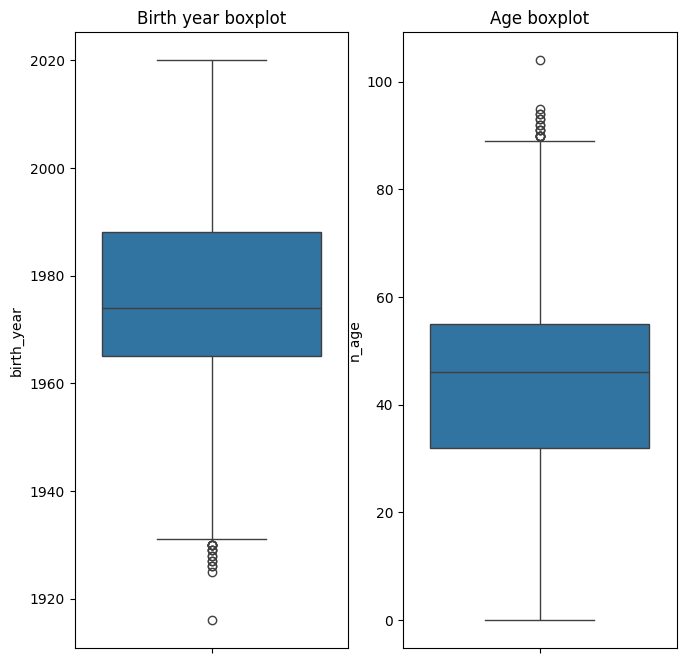

In [42]:
# boxplot (we will need to exclude the columns functioning as unique identifiers)
plt.figure(figsize=(12,8))
plt.subplot(1, 3, 2)
sns.boxplot(data=df['birth_year']).set(title='Birth year boxplot')
plt.subplot(1, 3, 3)
sns.boxplot(data=df['n_age']).set(title='Age boxplot')
plt.show();

Observations:
* Birth year shows there are more outliers seen between 1920 and 1930 with 1 person that was born before 1920.
* Age was the reverse (obviously) as the outliers were between Age 85 and 95 with 1 person over 100 years old.

**<font color='teal'> Create dummy features for object type features. </font>**

In [43]:
# check head of dfo dataframe
dfo.head()

,sex,age,country,province,city,infection_case,state
0,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,released
1,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,released
2,male,50s,Korea,Seoul,Jongno-gu,contact with patient,released
3,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,released
4,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,released


In [44]:
#creating the features - we need to drop 'state' because its the target variable
features = dfo.drop(['state'],axis=1)

#creating dummies for 'features'
df_dummies = pd.get_dummies(features,dtype=int)
df_dummies.head(3)

,sex_female,sex_male,age_0s,age_100s,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


### Split the data into test and train subsamples

In [45]:
#compiling the final full dataset after dummies created
df_temp = pd.concat([df, df_dummies], axis=1)
df1 = df_temp.drop(features, axis=1)

In [46]:
## print out each df that was created
df1.head()

,patient_id,global_num,birth_year,disease,infection_order,infected_by,contact_number,state,n_age,sex_female,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,2.0,1964,0,1.0,2.600789e+09,75.0,released,56,0,...,0,0,0,0,0,0,0,0,0,1
1,1000000002,5.0,1987,0,1.0,2.600789e+09,31.0,released,33,0,...,0,0,0,0,0,0,0,0,0,1
2,1000000003,6.0,1964,0,2.0,2.002000e+09,17.0,released,56,0,...,0,0,0,0,0,1,0,0,0,0
3,1000000004,7.0,1991,0,1.0,2.600789e+09,9.0,released,29,0,...,0,0,0,0,0,0,0,0,0,1
4,1000000005,9.0,1992,0,2.0,1.000000e+09,2.0,released,28,1,...,0,0,0,0,0,1,0,0,0,0


In [47]:
## df_temp
df_temp.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,...,0,0,0,0,0,0,0,0,0,1
1,1000000002,5.0,male,1987,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,...,0,0,0,0,0,0,0,0,0,1
2,1000000003,6.0,male,1964,50s,Korea,Seoul,Jongno-gu,0,contact with patient,...,0,0,0,0,0,1,0,0,0,0
3,1000000004,7.0,male,1991,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,...,0,0,0,0,0,0,0,0,0,1
4,1000000005,9.0,female,1992,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,...,0,0,0,0,0,1,0,0,0,0


In [48]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
# define X and y
features_f = df1.columns.drop(['state'])

X = df1[features_f]
y = df1['state']


# setup train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Scale data to prep for model creation

In [49]:
#scale data
from sklearn import preprocessing
import numpy as np


# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [50]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.856
Random Forest: f1-score=0.828


## Additional Evaluation Metrics
* Precision
* Recall
* Precision-Recall Curve
* AUC-ROC curve

In [59]:
## target_names
class_names=['isolated','released','deceased'] # name  of classes

### Precision and Recall

In [60]:
print(f"The precision score is: {precision_score(y_test, y_pred, average='weighted'):.2f}%")

The precision score is: 0.83%


In [61]:
print(f"The recall score is: {recall_score(y_test,y_pred, average='weighted'):.2f}%")

The recall score is: 0.86%


### ROC-AUC
* Note: The One-vs-the-Rest (OvR) multiclass strategy, also known as one-vs-all, consists in computing a ROC curve per each of the n_classes. In each step, a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk.

In [55]:
# Compute the ROC AUC score
print(f"The AUC score is: {roc_auc_score(y_test, y_pred_prob,average='weighted',multi_class='ovr'):.2f}%")


The AUC score is: 0.81%


## Observations on ROC-AUC Curve

* The AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability.
* It tells how much the model is capable of distinguishing between classes.
    * The Higher the AUC, the better the model is at predicting each target class: deceased, released or isolated.

* The ROC curve is plotted with the true-positive ratio (TPR) against the false-positive ratio (FPR) where TPR is on the y-axis and FPR is on the x-axis. I was not able to plot the mult-class curve.
* However, we can say that an AUC score of 81% means the Random Forest Model as a whole can more than likely predict the correct class or true positives 81% of the time. We will examine the Confusion Matrix for the true prediction percentages below.

## Observations on Precision, Recall and F1 score
* The precision is 83% and the recall is 86%, thus the precision is lower than the recall. The reason the precision is lower could be that we are predicting more false positives. We will see this in the confusion matrix below.

* The **F1 score** is the arithmetic mean of precision and recall and is really not an appropriate measure to evaluate machine learning classifier performance because it **does not account for cases where one value is much lower than the other.**
  * As an example, if a classifier has a very high precision but a low recall, its overall performance would not be good.
  * The harmonic mean in the F1-Score gives **more weight to the lower value,** which means that a low value in either precision or recall will result in a low F1-score.

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

Confusion matrix, without normalization
[[  6   0   0]
 [  0 358  11]
 [  0  53  16]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.97 0.03]
 [0.   0.77 0.23]]


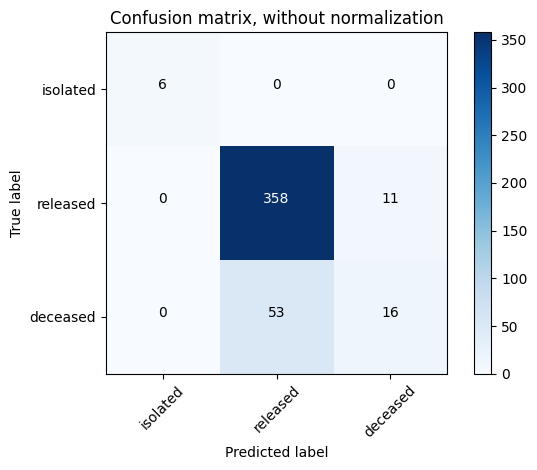

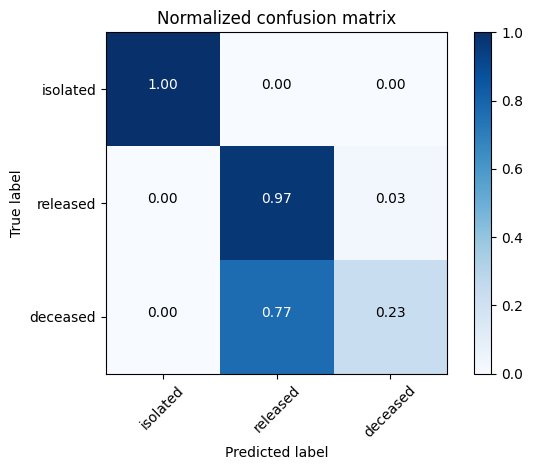

In [62]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show();

## Summary of Confusion Matrix

Confusion Matrix without normalization
* This matrix shows the absolute number of predictions for each class.
The rows represent the actual classes and the columns represent the predicted classes.
The diagonal elements represent the number of points for which the predicted label is equal to the true label,
while off-diagonal elements are those that are mislabeled by the classifier.
The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
As we can see right away the highest and most confident prediction was a patient being released at 358.
* The first row of this matrix considers the first class or Class 1 ("isolated"): 6 were correctly predicted as Class 1 (true positives). None were incorrectly predicted as Class 2 ("released") or Class 3("deceased") (these would be false positives if they existed).
* The second row is about Class 2 which is "released": 358 were correctly predicted as Class 2 ("released"), and 11 were incorrectly predicted as Class 3 ("deceased").
* The third row is about Class 3 which is "deceased": 16 were correctly predicted as Class 3 ("deceased"), but 53 were incorrectly predicted as Class 2 ("released").
  * I had predicted earlier in this notebook during exploratory data analysis that the significant imbalance in the target variables would lead to poorer predictions on the imbalanced classes which it did.


Normalized Confusion Matrix

* This matrix shows the same information as the first matrix, but the values are normalized to range between 0 and 1, representing the proportion of predictions for each class. This can make it easier to compare the classifier performance across different classes.
* The first row shows that 100% of Class 1 ("isolated") instances were correctly predicted.
* The second row shows that 97% of Class 2 ("released") instances were correctly predicted, and 3% were incorrectly predicted as Class 3 ("deceased").
* The third row shows that only 23% of Class 3 ("deceased") instances were correctly predicted, and 77% were incorrectly predicted as Class 2 ("released").

* **In summary, the classifier seems to perform well on Class 1 (isolated) and Class 2 (released), but struggles with Class 3 ("deceased"), often misclassifying it as Class 2. We know this result is more than likely occurring because of the significant imbalance in the target variables we started with prior to building the Random Forest Classifier model. Due to the fact we started with a count of 1791 isolated, 307 released and 32 deceased, the model is naturally going to predict more true positives for the classes with more weight which in this case were Class 1 and 2.





### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


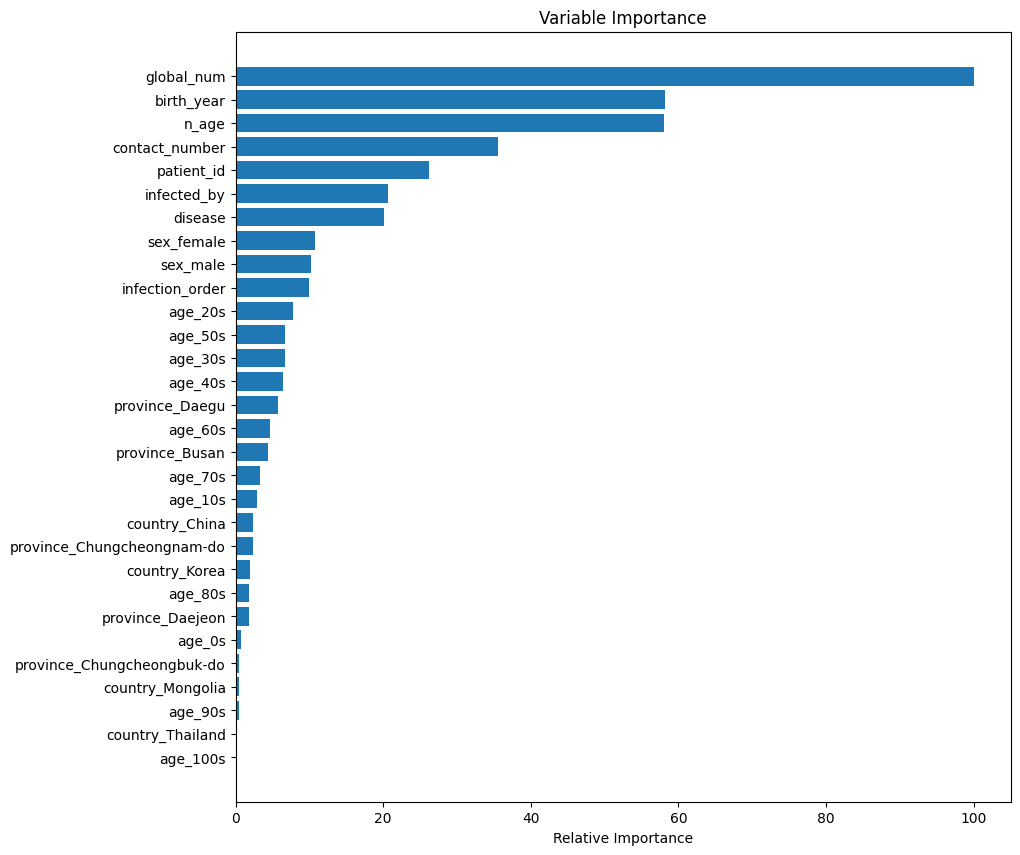

In [57]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))

## set up horizontal bar plot
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show();

# Summary
* The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not.
* In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
* Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.

## Additional Summary and Observations
* Looking more closely at the variable importance from the Random Forest Clasifier we can see:
1. The most important variables were:
  * global num
  * birth year
  * n_age
  * contact_number

2. Least important variables:
  * age_100s
  * country_Thailand
  * age_90s
  * country_Mongolia

3. "Middle of the road importance"
* Ages of 20s, 50s, 30s and 40s in that order.
* This is interesting as we did find during exploratory data analysis that the distribution of the ages of the patients was bi-modal with the mean and median and the highest peak focused around the 40s and the 2nd peak was around the 20s.

4. Both Male and Female were the same level of feature importance.


## **The Random Forest classifier seems to perform well on predicting Class 1 (isolated) and Class 2 (released), but struggles with Class 3 (deceased), often misclassifying it as Class 2.**
    * I would want to continue this analysis with more data, especially with more balanced target variable classes. * We do know that worldwide, as of May 2023 data, South Korea accounts for only 0.5% of the worlds death rate from COVID-19 whereas the USA accounts for 16.9% of the world's death rate at #1 on the list. So by default, South Korea is going to have less data on deceased patients and thus we would naturally predict less death just to put this in context.
    * We also know that as of August 2023, the death rate for South Korea for age 80+ years is 1.72% and age 70-79 is 0.4% which is **1.76% total for these 2 elderly age groups worldwide.**
    * By contrast, the USA worldwide COVID-19 death rate for elderly patients? The USA has 27.4% of the COVID-19 deaths for age 85+ years and 26.2% of the COVID-19 deaths for age 75-84, this is **53.6% total for these 2 elderly age groups worldwide.**
    * The point here is that the South Korea data by default we saw has an imbalanced age distribution with younger patients between 20 and 45 that were isolated and significantly less patients age 70 and above, and overall a significantly lower death rate than the rest of the world.
    * So can we assume our model correctly predicted patients will be more likely to be isolated or released in South Korea? Yes. However, there were quite a few false positive predictions with the deceased class because of the class imbalance so we need to approach these predictions cautiously.
    * Going forward we could consider different feature engineering techniques to prepare the data for machine learning, in addition to using hyperparameter tuning and GridSearchCV to perform cross validation and finetune the model.

## References
* https://www.statista.com/statistics/1105088/south-korea-coronavirus-mortality-rate-by-age/
* https://www.statista.com/statistics/1254488/us-share-of-total-covid-deaths-by-age-group/
